This notebook demonstrates popular ways of preprocessing data of different nature, it can be perceived as a template for your own developments and notes, all the code was written for training. The dataset used here is TMDB 5000 Movie Dataset

In [1]:
# installing modules for visualization + text embeddings
!pip install vapeplot > 0
!pip install -U sentence-transformers > 0

In [3]:
import pandas as pd
import numpy as np

import torch

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# text preprocessing into embeddings/vectors
from sentence_transformers import SentenceTransformer

# ignoring some warnings
import warnings
warnings.filterwarnings("ignore")

# visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot

# custom color pallete
vapeplot.set_palette('cool')

In [6]:
df_original = pd.read_csv('tmdb_5000_movies.csv')
df = df_original.copy()

## Preprocessing + selection

Firstly, it is necessary to examine the data, get rid of omissions and divide them into subsets of the same nature, which will be processed differently

In [7]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

I've decided to select next columns:

In [9]:
col_stat = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
col_time = ['release_date']
col_cat = ['original_language']
col_ner = ['original_title', 'overview', 'title']

In [10]:
# selecting all int/float values != 0
df = df[(df[col_stat] != 0).all(axis=1)]

# selecting only necessary columns
df = df[col_stat + col_time + col_cat + col_ner].reset_index(drop=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227 entries, 0 to 3226
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             3227 non-null   int64  
 1   popularity         3227 non-null   float64
 2   revenue            3227 non-null   int64  
 3   runtime            3227 non-null   float64
 4   vote_average       3227 non-null   float64
 5   vote_count         3227 non-null   int64  
 6   release_date       3227 non-null   object 
 7   original_language  3227 non-null   object 
 8   original_title     3227 non-null   object 
 9   overview           3227 non-null   object 
 10  title              3227 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 277.4+ KB


## Stat features

Let's look at the distributions of numerical data to understand how to normalize them.

In [12]:
def show_col_stat(title):
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(8, 10), layout='constrained')
    
    indx = 0
    for i in range(rows):
        for j in range(cols):
            sns.histplot(data=df[col_stat[indx]], ax=axes[i, j], kde=True)
            axes[i, j].set_xlabel(col_stat[indx])
            axes[i, j].grid(True)
            indx += 1
    
    fig.suptitle(title)
    plt.show()

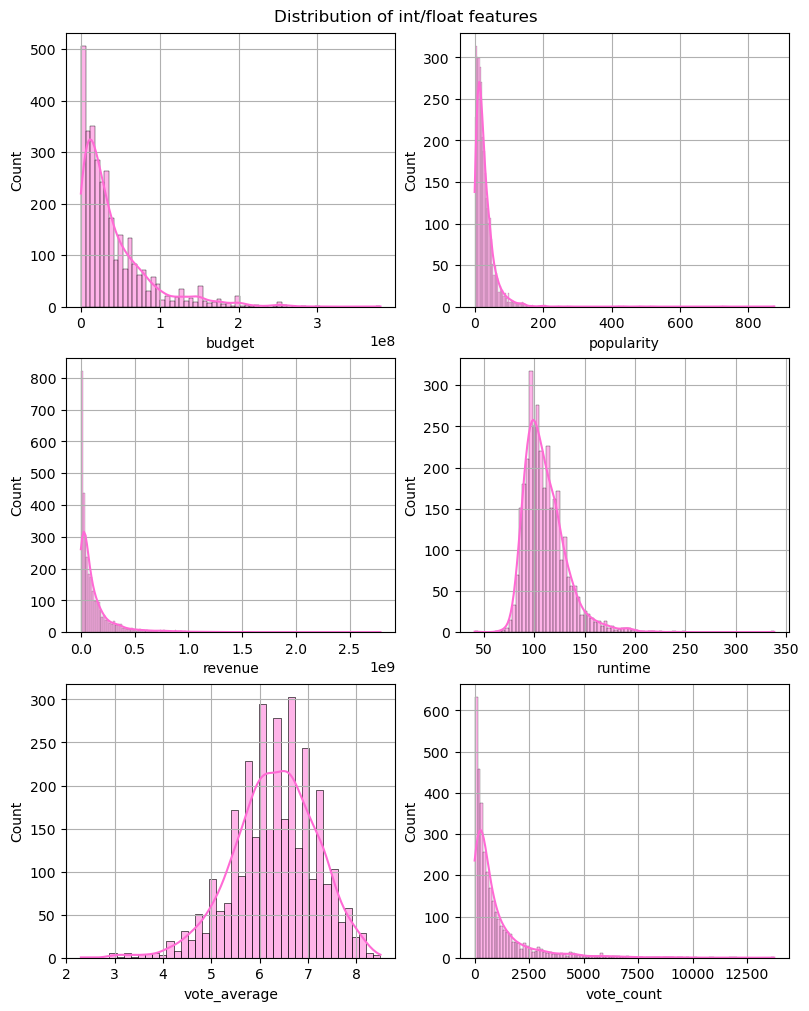

In [13]:
show_col_stat('Distribution of int/float features')

Some distributions have a **lognormal** nature, so let's **logarithm** them first. We will also bring everything to the **standard normal distribution**, i.e. we center it according to the **mathematical expectation** relative to **0** with a **variance of 1**

In [14]:
# logarithming lognormal data
df.budget = df.budget.apply(np.log1p)
df.popularity = df.popularity.apply(np.log1p)
df.revenue = df.revenue.apply(np.log1p)
df.vote_count = df.vote_count.apply(np.log1p)

In [15]:
# normalizing to standard normal distribution
df[col_stat] = StandardScaler().fit_transform(df[col_stat])

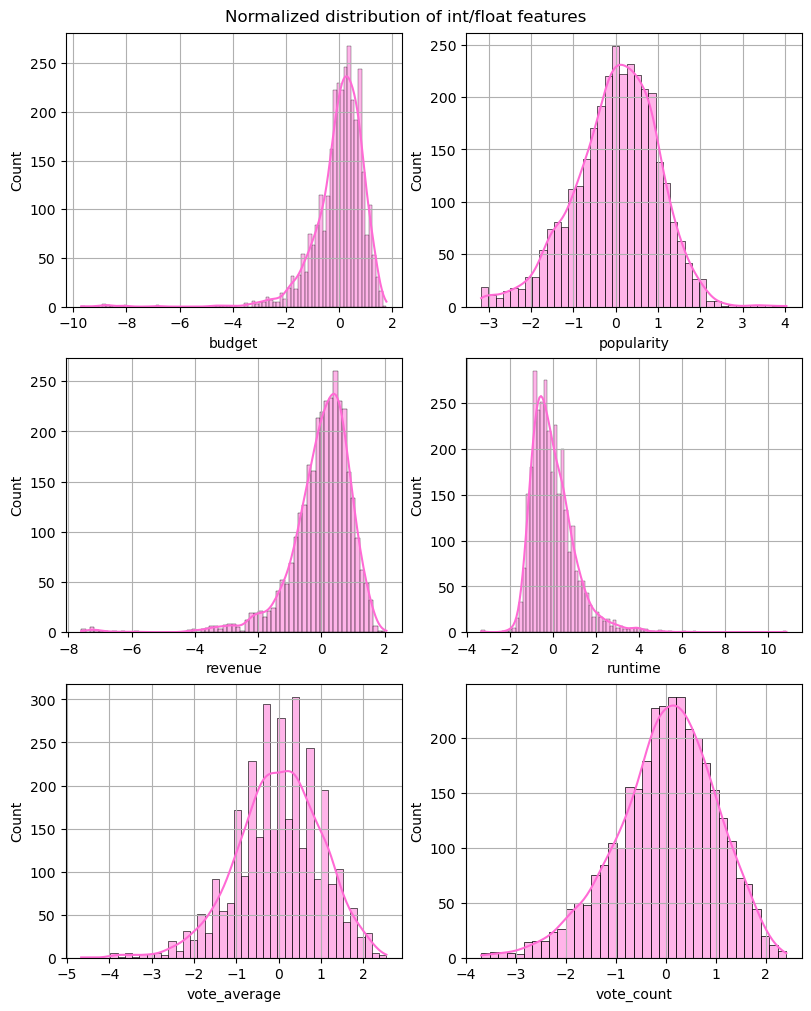

In [16]:
show_col_stat('Normalized distribution of int/float features')

## Time features

With time data, let's try to take into account the nature of time cycling. First, we divide everything into year, month and day, and then we bring the month and day to a trigonometric representation using sine and cosine

In [17]:
# splitting strings
df['release_date'] = df['release_date'].apply(lambda x: list(map(int, x.split('-'))))

In [18]:
# selecting year
df['year'] = df['release_date'].apply(lambda x: x[0])

In [19]:
# trigonometric representation of months
df['month sin'] = df['release_date'].apply(lambda x: np.sin(2 * np.pi * x[1] / 12))
df['month cos'] = df['release_date'].apply(lambda x: np.cos(2 * np.pi * x[1] / 12))

In [20]:
# trigonometric representation of days
df['day cos'] = df['release_date'].apply(lambda x: np.cos(2 * np.pi * x[2] / 30))
df['day sin'] = df['release_date'].apply(lambda x: np.sin(2 * np.pi * x[2] / 30))

In [21]:
# dropping previous date representation
df = df.drop(columns=['release_date'])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227 entries, 0 to 3226
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             3227 non-null   float64
 1   popularity         3227 non-null   float64
 2   revenue            3227 non-null   float64
 3   runtime            3227 non-null   float64
 4   vote_average       3227 non-null   float64
 5   vote_count         3227 non-null   float64
 6   original_language  3227 non-null   object 
 7   original_title     3227 non-null   object 
 8   overview           3227 non-null   object 
 9   title              3227 non-null   object 
 10  year               3227 non-null   int64  
 11  month sin          3227 non-null   float64
 12  month cos          3227 non-null   float64
 13  day cos            3227 non-null   float64
 14  day sin            3227 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 378.3+ KB


In [23]:
df.head(3)

,budget,popularity,revenue,runtime,vote_average,vote_count,original_language,original_title,overview,title,year,month sin,month cos,day cos,day sin
0,1.494643,2.160344,2.056632,2.445697,1.031344,2.307731,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",Avatar,2009,-2.449294e-16,1.000000,-0.500000,0.866025
1,1.636597,2.077043,1.541457,2.779553,0.682420,1.641159,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,2007,5.000000e-01,-0.866025,-0.669131,-0.743145
2,1.514635,1.802775,1.499237,1.777985,-0.015426,1.635915,en,Spectre,A cryptic message from Bond’s past sends him o...,Spectre,2015,-8.660254e-01,0.500000,0.669131,-0.743145


## Categorical features

I've decided to choose a column with languages as categorical features, since there are a limited number of them. First, let's look at their frequency of occurrence, and then filter out those that are more common than others

In [24]:
# categories' freqs
category_counts = df.original_language.value_counts()

In [25]:
# selectings langs thats freq > 5
categories_to_keep = category_counts[category_counts > 5].index
df_filtered = df[df.original_language.isin(categories_to_keep)].reset_index(drop=True)

In [26]:
# let's use OneHot with dropping first column in order to encode features
encoder = OneHotEncoder(drop='first')

In [27]:
# encoding columns
encoded_columns = pd.DataFrame(encoder.fit_transform(df_filtered[col_cat]).toarray())
encoded_columns.head(3)

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# concating encoded columns with df
df = pd.concat([df_filtered.drop(columns=col_cat), encoded_columns], axis=1)
df.columns = list(df.columns[:-encoded_columns.shape[1]]) + list(encoder.get_feature_names_out())
df.head(100)

,budget,popularity,revenue,runtime,vote_average,vote_count,original_title,overview,title,year,...,day cos,day sin,original_language_en,original_language_es,original_language_fr,original_language_hi,original_language_it,original_language_ja,original_language_ru,original_language_zh
0,1.494643,2.160344,2.056632,2.445697,1.031344,2.307731,Avatar,"In the 22nd century, a paraplegic Marine is di...",Avatar,2009,...,-0.500000,0.866025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.636597,2.077043,1.541457,2.779553,0.682420,1.641159,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,2007,...,-0.669131,-0.743145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.514635,1.802775,1.499237,1.777985,-0.015426,1.635915,Spectre,A cryptic message from Bond’s past sends him o...,Spectre,2015,...,0.669131,-0.743145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.526801,1.850378,1.600131,2.588778,1.496575,2.128523,The Dark Knight Rises,Following the death of District Attorney Harve...,The Dark Knight Rises,2012,...,-0.978148,-0.207912,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.550420,0.861637,0.952075,1.014885,-0.248042,1.122133,John Carter,"John Carter is a war-weary, former military ca...",John Carter,2012,...,0.104528,0.994522,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.258043,2.274980,1.467962,1.777985,2.078113,2.413588,Inception,"Cobb, a skilled thief who commits corporate es...",Inception,2010,...,-0.978148,0.207912,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,-0.167458,-0.694347,0.320541,0.442560,0.217189,-0.739314,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,Shin Godzilla,2016,...,0.978148,-0.207912,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,1.526801,1.817202,1.570800,2.779553,0.798728,2.064189,The Hobbit: An Unexpected Journey,"Bilbo Baggins, a hobbit enjoying his quiet lif...",The Hobbit: An Unexpected Journey,2012,...,0.669131,-0.743145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.392316,-0.994740,0.799532,-0.225152,0.333497,1.453037,The Fast and the Furious,Domenic Toretto is a Los Angeles street racer ...,The Fast and the Furious,2001,...,-0.104528,-0.994522,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Text features

I usually use classic methods of text preprocessing and normalization, but this time I've decided to try vector representation using [transformers](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

In [31]:
# choosing gpu for transformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
# loading the model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)

In [33]:
embeddings = []

# collecting embeddings for each text columns
for col in col_ner:
    sentences = df[f'{col}'].to_list()
    
    # emdedding length is 768
    embeds = model.encode(sentences)
    embeddings.append(pd.DataFrame(embeds))

In [34]:
# concating new embeddings with df and dropping previous text cols
encoded_df = pd.concat([df] + embeddings, axis=1)
encoded_df = encoded_df.drop(columns=col_ner)

# the final encoded result
encoded_df

,budget,popularity,revenue,runtime,vote_average,vote_count,year,month sin,month cos,day cos,...,758,759,760,761,762,763,764,765,766,767
0,1.494643,2.160344,2.056632,2.445697,1.031344,2.307731,2009,-2.449294e-16,1.000000e+00,-0.500000,...,-0.004097,0.023413,-0.003896,0.025614,-0.000895,0.047409,0.024157,0.050225,-0.039656,-0.031700
1,1.636597,2.077043,1.541457,2.779553,0.682420,1.641159,2007,5.000000e-01,-8.660254e-01,-0.669131,...,-0.072049,0.042996,0.015878,0.032993,0.016183,0.023371,0.032709,0.001076,0.003870,-0.018172
2,1.514635,1.802775,1.499237,1.777985,-0.015426,1.635915,2015,-8.660254e-01,5.000000e-01,0.669131,...,0.045760,-0.025729,0.042732,-0.014486,0.014943,-0.078798,-0.012726,0.040711,-0.026912,0.000037
3,1.526801,1.850378,1.600131,2.588778,1.496575,2.128523,2012,-5.000000e-01,-8.660254e-01,-0.978148,...,-0.029404,-0.008736,-0.009867,-0.004307,-0.016897,-0.010385,0.020566,0.008895,0.007753,0.004020
4,1.550420,0.861637,0.952075,1.014885,-0.248042,1.122133,2012,1.000000e+00,6.123234e-17,0.104528,...,-0.046770,0.053564,0.042537,-0.027535,-0.023769,0.013855,-0.007186,0.008315,-0.035216,0.007669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,-3.973373,0.035946,-1.225354,-0.892865,1.263959,0.407429,1994,-1.000000e+00,-1.836970e-16,-0.913545,...,0.001489,0.027738,0.014239,0.023961,0.006033,0.051958,-0.000174,0.015917,0.009478,-0.003079
3190,-4.461694,-1.372730,-0.913858,-0.845171,-0.131734,-0.919312,1972,1.000000e+00,6.123234e-17,-0.809017,...,-0.035555,-0.008370,-0.013174,-0.029774,-0.029561,0.037155,-0.052166,0.052006,-0.000656,0.000119
3191,-4.154091,-2.999211,-2.899109,0.013316,1.263959,-1.300111,1997,-5.000000e-01,8.660254e-01,0.309017,...,-0.008677,0.041599,-0.004181,-0.022523,0.004309,0.043475,0.009843,0.006154,-0.040828,-0.032118
3192,-4.786246,0.205157,-2.194664,-1.608271,0.682420,0.312467,2004,-8.660254e-01,5.000000e-01,-0.104528,...,-0.014474,-0.013025,-0.045100,0.020041,-0.023024,0.069388,0.017356,0.035628,-0.075941,-0.029771


It is worth noting that the feature space turned out to be very large in relation to the number of objects in the data *(3194 objects and 2323 features)*. For practical purposes, it is better to aggregate text embeddings *(mean or sum)* and somehow reduce the number of features using dimensionality reduction methods *(PCA, t-SNE and others)*

## JSON data

This is a small example of how I tried to choose some kind of target, for example, one genre. Unfortunately, I took the very first genre from the sorted ones in the json file, which is a bit bad. I think ideally you can take all genres and try to build some kind of recommendation system based on them

In [40]:
import json

def json10genre(x):
    js = json.loads(x)
    return js[0]['name'] if js else None

In [ ]:
df_original.genres = df_original.genres.apply(json10genre)
df_original.genres.head()